In [58]:
import os
import glob
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from copy import deepcopy

from gensit.config import Config
from gensit.inputs import Inputs
from gensit.outputs import Outputs
from gensit.utils.misc_utils import *
from gensit.utils.math_utils import *
from gensit.utils.probability_utils import *
from gensit.contingency_table import instantiate_ct
from gensit.markov_basis import instantiate_markov_basis

In [59]:
%matplotlib inline

# AUTO RELOAD EXTERNAL MODULES
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import samples

In [60]:
# Specify experiment id
experiment_id = "RSquared_Analysis_LowNoise__total_constrained_12_04_2024_18_26_05"
config_id = 'experiment_r_squared'
# 'experiment1_disjoint'
# 'experiment_r_squared'
# Specify experiment group id
dataset = 'DC'
#'DC'
#'cambridge_work_commuter_lsoas_to_msoas'
#'sioux_falls'
experiment_group_id = 'r_squared/'
experiment_dir = f'../data/outputs/{dataset}/{experiment_group_id}/{experiment_id}/'
relative_experiment_dir = os.path.relpath(experiment_dir,os.getcwd())

In [61]:
# Create new logging object
logger = setup_logger(
    __name__,
    console_level = 'INFO',
    file_level = 'EMPTY'
)

In [62]:
# Output processing settings
settings = {
    "logging_mode": "INFO",
    "coordinate_slice": [
        "da.destination_attraction_ts == str('destination_attraction_demand_ts_sum_normalised.txt')",
        "da.cost_matrix == str('cost_matrix_large_diagonal_sum_normalised.txt')",
        "da.bmax == 10944.0"
        # "da.loss_name == str(['dest_attraction_ts_likelihood_loss'])",
        # "~da.title.isin([str('_unconstrained'), str('_total_constrained')])"
    ],
    "metadata_keys":[],
    "burnin_thinning_trimming": [],
    # {'iter': {"burnin":10000, "thinning":90, "trimming":1000}}
    "n_workers": 1,
    "group_by":[],
    "filename_ending":"test",
    "sample":["r2"],
    "force_reload":True
}

: 

In [52]:
# Initialise outputs
current_sweep_outputs = Outputs(
    config = os.path.join(relative_experiment_dir,"config.json"),
    settings = settings,
    inputs = None,
    slice = True,
    level = 'INFO'
)
# Silence outputs
current_sweep_outputs.logger.setLevels(console_level='EMPTY')
# Load all data
current_sweep_outputs.load()

44:24.351 config INFO ----------------------------------------------------------------------------------
44:24.359 config INFO Parameter space size: 
 --- destination_attraction_ts (4)
 --- cost_matrix (2)
 --- bmax (5)
44:24.368 config INFO Total = 40.
44:24.375 config INFO ----------------------------------------------------------------------------------
44:24.412 outputs INFO //////////////////////////////////////////////////////////////////////////////////
44:24.420 outputs INFO Slicing coordinates:
44:24.428 outputs INFO destination_attraction_ts == str('destination_attraction_demand_ts_sum_normalised.txt')
44:24.436 outputs INFO cost_matrix == str('cost_matrix_large_diagonal_sum_normalised.txt')
44:24.444 outputs INFO bmax == 10944.0
44:24.452 outputs INFO //////////////////////////////////////////////////////////////////////////////////


../data/outputs/DC/r_squared/RSquared_Analysis_LowNoise__total_constrained_12_04_2024_18_26_05/sample_collections


In [53]:
# conf = Config(
#     path = os.path.join(relative_experiment_dir,"config.json")
# )
# ins = Inputs(
#     config = conf
# )
# ins.cast_to_xarray()

# $R^2$ analysis

In [54]:
data_index = 0
sweep_outputs_slice = current_sweep_outputs.get(data_index)

In [55]:
sweep_outputs_slice.data.r2.coords

Coordinates:
  * alpha_range                (alpha_range) int32 1 2 3 4 5 ... 21 22 23 24 25
  * beta_range                 (beta_range) int32 1 2 3 4 5 6 ... 21 22 23 24 25
  * sweep                      (sweep) object MultiIndex
  * destination_attraction_ts  (sweep) <U51 'destination_attraction_demand_ts...
  * cost_matrix                (sweep) <U45 'cost_matrix_large_diagonal_sum_n...
  * bmax                       (sweep) float32 1.094e+04

In [56]:
r2 = sweep_outputs_slice.data.r2
alpha_range = current_sweep_outputs.config['experiments'][0]['grid_ranges']['alpha']
r2['alpha_range'] = np.linspace(alpha_range['min'],alpha_range['max'],alpha_range['n'],endpoint=True)
r2['alpha_range'] = r2['alpha_range'].values
beta_range = current_sweep_outputs.config['experiments'][0]['grid_ranges']['beta']
r2['beta_range'] = np.linspace(beta_range['min'],beta_range['max'],beta_range['n'],endpoint=True)
r2['beta_range'] = r2['beta_range'].values

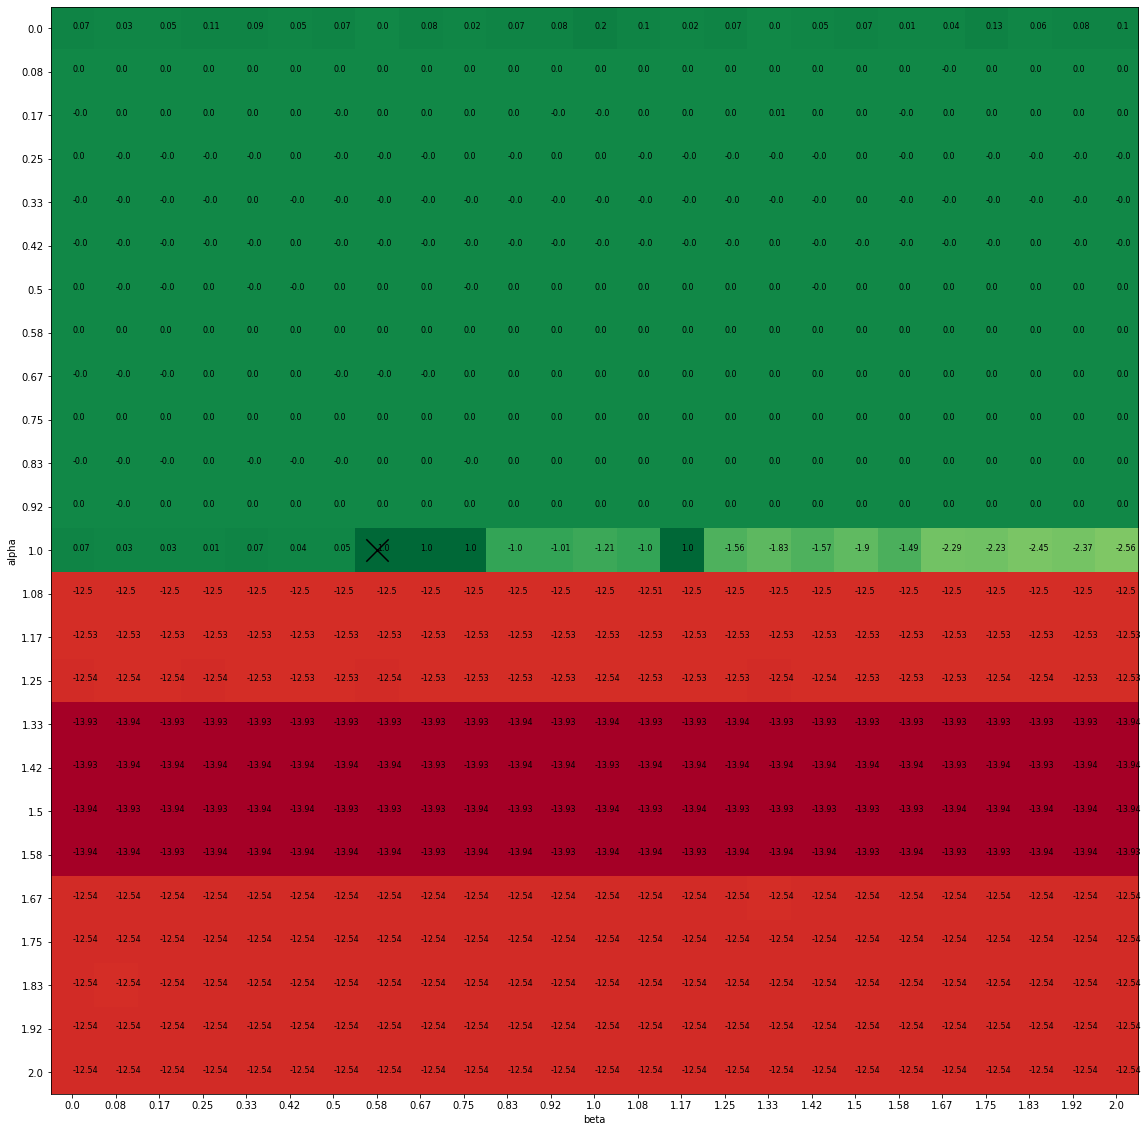

In [57]:
argmax_index = np.unravel_index(np.argmax(r2.values.squeeze()), np.shape(r2.values.squeeze()))
plt.figure(figsize=(20,20))
plt.imshow(r2, cmap='RdYlGn', interpolation='nearest')
plt.scatter(argmax_index[1],argmax_index[0],marker='x',color='black',s=500)
plt.yticks(ticks=range(len(r2['alpha_range'])),labels=np.round(r2['alpha_range'].values,2))
plt.ylabel('alpha')
plt.xticks(ticks=range(len(r2['beta_range'])),labels=np.round(r2['beta_range'].values,2))
plt.xlabel('beta')
for i in range(len(r2['alpha_range'])):
    for j in range(len(r2['beta_range'])):
        plt.text(j,i,s=np.round(r2.squeeze().values[i,j],2),fontsize=8)
plt.show()

# SIM Analysis